## 0: Section Overview

In the following documentation, we will explore the use of auto-encoders to address the question: Can we predict artist preferences for users based off left-out test data? We want to evaluate the computational performance of this model, while applying it to make predictions based off user data on artist preferences. Thus we will also address the question: How can different approaches to a recommender system affect the computational performance of our models?

## 1: Necessary Imports

In [32]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## 2: Data Access and Preparation

Our data is available in our GitHub repository in the file 'Data'.

In [6]:
path1 = '../data/user_artists.dat'
path2 = '../data/artists.dat'

user_data = pd.read_csv(path1, sep='\t')
artist_ids = pd.read_csv(path2, sep='\t')

We will now split the data into a test and train set so that we can evaluate our model on unseen data. We will then split the test set further into `test_x` and `test_y` such that we can use `test_x` to generate a prediction using our model, and `test_y` to evaluate this prediction. The train and test set will be split so that they contain mutually exclusive users, and 80% of the data is used for the train set and 20% for the test set. The test set will then be split so that 50% of each user's data is in `test_x` and `test_y`. This makes sense in the context of the problem since I want to ensure that the model has enough input data to provide a good prediction, but also enough verification data to accurately measure its performance. For this model, performance can be considered 'good' if many of its recommendations from `test_x` can also be observed in `test_y`, however there is a certain amount of randomness in this approach. Potentially the model could be providing 'good' predictions, but by chance, these do not correspond to the user's preferences in `test_y`. This is why we dedicate more data than is standard practice to the `test_y` set, to give a greater chance of the model's 'good' performance being recognised.

In [13]:
user_interaction_counts = user_data.groupby('userID').size()
users_with_50_interactions = user_interaction_counts[user_interaction_counts >= 50].index
user_data_filtered = user_data[user_data['userID'].isin(users_with_50_interactions)]

unique_users = user_data_filtered['userID'].unique()

# Ensure that test users have at least 50 interactions in 'test_data'

np.random.seed(42)

shuffled_users = np.random.permutation(unique_users)

train_users = []
test_users = []

# Collect test users until we have enough that have at least 50 interactions
for user in shuffled_users:
    user_data_temp = user_data_filtered[user_data_filtered['userID'] == user]
    if len(test_users) < int(0.2 * len(unique_users)):
        test_users.append(user)
    else:
        train_users.append(user)

# Recreate test_data and train_data
train_data = user_data_filtered[user_data_filtered['userID'].isin(train_users)]
test_data = user_data_filtered[user_data_filtered['userID'].isin(test_users)]

# Now check that each user in test_data has 50 interactions
# Remove any users from test_users who don't meet this criterion
valid_test_users = []
for user in test_users:
    user_data_temp = test_data[test_data['userID'] == user]
    if len(user_data_temp) == 50:
        valid_test_users.append(user)

# Update test_users and test_data
test_users = valid_test_users
test_data = test_data[test_data['userID'].isin(test_users)]

# Update train_data to include any users removed from test_users
removed_test_users = set(shuffled_users) - set(train_users) - set(test_users)
if removed_test_users:
    train_users.extend(list(removed_test_users))
    train_data = user_data_filtered[user_data_filtered['userID'].isin(train_users)]

# Split test_data into test_x and test_y
test_x = pd.DataFrame(columns=test_data.columns)
test_y = pd.DataFrame(columns=test_data.columns)

for user in test_users:
    user_data_temp = test_data[test_data['userID'] == user]
    user_data_shuffled = user_data_temp.sample(frac=1, random_state=42)
    user_test_x = user_data_shuffled.iloc[:25]
    user_test_y = user_data_shuffled.iloc[25:50]
    test_x = pd.concat([test_x, user_test_x], ignore_index=True)
    test_y = pd.concat([test_y, user_test_y], ignore_index=True)

Next we will encode our data using `LabelEncoder()` which converts categorical variables into numerical representations. Although our values are already numerical in this case, using an encoder can still be useful for ensuring the indices are compact and suitable for tensor or matrix operations, and also as a method for decoding indices back to original IDs for interpretability.

In [14]:
# Encode artistIDs
artist_encoder = LabelEncoder()
all_artistIDs = user_data_filtered['artistID'].unique()
artist_encoder.fit(all_artistIDs)
num_artists = len(artist_encoder.classes_)

# Encode train users
train_user_encoder = LabelEncoder()
train_user_encoder.fit(train_users)
num_train_users = len(train_user_encoder.classes_)

# Encode test users
test_user_encoder = LabelEncoder()
test_user_encoder.fit(test_users)
num_test_users = len(test_user_encoder.classes_)

Now, we will create a user-item interaction matrix, and will scale our data before inputting it into the autoencoder. A user-interaction matrix is a structured and computationally efficient way to represent user preferences since its structure allows VAEs to leverage GPU acceleration for faster training, which we will see later. Data normalisation is essential for improving training efficiency, and preventing instability. If the data has a wide range of values, the model's weights may not converge during training, whearas for normalised data, the optimisation process becomes more stable and faster.

In [15]:
# Function to create user-item interaction matrix
def create_user_item_matrix(data, user_encoder, num_users):
    user_item_matrix = np.zeros((num_users, num_artists))
    for idx, row in data.iterrows():
        user_idx = user_encoder.transform([row['userID']])[0]
        artist_idx = artist_encoder.transform([row['artistID']])[0]
        weight = row['weight']
        user_item_matrix[user_idx, artist_idx] = weight
    return user_item_matrix

train_user_item_matrix = create_user_item_matrix(train_data, train_user_encoder, num_train_users)
test_x_user_item_matrix = create_user_item_matrix(test_x, test_user_encoder, num_test_users)
test_y_user_item_matrix = create_user_item_matrix(test_y, test_user_encoder, num_test_users)

# Scale data before inputting it into autoencoder
# Find the maximum and minimum values across all matrices for consistent scaling
max_value = max(train_user_item_matrix.max(), test_x_user_item_matrix.max(), test_y_user_item_matrix.max())
min_value = min(train_user_item_matrix.min(), test_x_user_item_matrix.min(), test_y_user_item_matrix.min())

# Define a function to normalise a matrix
def normalise(matrix, min_value, max_value):
    return (matrix - min_value) / (max_value - min_value)

# Normalise each matrix
train_user_item_matrix = normalise(train_user_item_matrix, min_value, max_value)
test_x_user_item_matrix = normalise(test_x_user_item_matrix, min_value, max_value)
test_y_user_item_matrix = normalise(test_y_user_item_matrix, min_value, max_value)

## 3: Variational Autoencoders

### 3.1: Model Definition

We will now define the autoencoder using object oriented programming. In the context of our problem, variational autoencoders (VAEs) will be useful since they provide a probabilistic approach to autoencoders. Unlike standard autoencoders, VAEs model the latent space as a continuous, smooth distribution with the learned parameters of mean and (log-)variance. Thus VAEs are generative as the model output is reconstructed from the latent space by sampling from the learned distribution. This generative property makes VAEs particularly appropriate for creating Recommender Systems since they address the cold-start problem, and problems associated data sparcity, by generating recommendations for unseen users effectively using the latent space distribution. Our VAE model consists of the functions: `__init__` , `encode`, `rreparametrise`, `decode`, and `forward`. The `__init__` function intialised the parameters of the input dimension, hidden dimension and latent dimension. The `encode` function respectively encodes to the latent space by outputting the mean and log-variance. `reparametrise` allows backprapogation by inputting the mean and log-variance and outputting a latent sample from $\mathcal{N}(\mu, \sigma^2)$, whilst also sampling noise from a standard normal distribution. Then the function `decode` decodes the latent variable z back to the original data space, and `forward` in the function that defines the forward pass of the VAE by combining the other functions.

In [16]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        logvar = torch.clamp(logvar, min=-10, max=10)
        return mu, logvar
    
    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = torch.relu(self.fc_decode(z))
        return torch.sigmoid(self.fc_out(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        return self.decode(z), mu, logvar

### 3.2: Model Training

Now we will train our model using the `train_user_item_matrix` created from our train dataset. We use a dataloader to implement batches which splits the data into smaller batches, so that only a smaller subset of the data is loaded into memory at any time, making the model more computationally efficient. Moreover, if a GPU is available, it can leverage the parallel computation capabilities of batches for efficient data processing, which speeds up training.

For readability, and to facilitate adapting the model later, we will use a series of functions to define the implementation of our model.

In [39]:
def train_model(train_user_item_matrix, artist_encoder):
    # Convert train data to tensor
    train_tensor = torch.FloatTensor(train_user_item_matrix)

    # Create DataLoader
    batch_size = 64
    train_dataset = torch.utils.data.TensorDataset(train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Initialise the model, optimiser, and loss function
    num_artists = len(artist_encoder.classes_)
    input_dim = num_artists
    hidden_dim = 256
    latent_dim = 50

    model = VAE(input_dim, hidden_dim, latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    def loss_function(recon_x, x, mu, logvar):
        MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data_batch in train_loader:
            data = data_batch[0]
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        # We have the option to print the loss at each epoch
        loss_at_epoch = train_loss / len(train_loader.dataset)

    model.eval()
    latent_mu_list = []
    latent_logvar_list = []

    with torch.no_grad():
        for data_batch in train_loader:  # or test_loader
            data = data_batch[0]
            mu, logvar = model.encode(data)
            latent_mu_list.append(mu)
            latent_logvar_list.append(logvar)

    latent_mu = torch.cat(latent_mu_list).cpu().numpy()

    return model, latent_mu

### 3.3: Model Testing

Now we will test our model using our test data. We will provide a variety of metrics which can each be used to judge model performance. MSE is the standard metric which measures the squared difference between the values of the reconstructed output, `predictions`, and the true values, `test_y_tensor`. The hit rate @ k measures the proportion of users for which at least one of their top-k predictions (the top-k elements of `predictions`), is also in `test_y_tensor`. The Normalised Discounted Cumulative Gain (NDCG) measures how well the model ranks relevant items along the top-k predictions, while taking into account the ranking of recommendations.

In [40]:
def test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric, k=5):

    # Convert test data to tensor
    test_x_tensor = torch.FloatTensor(test_x_user_item_matrix)
    test_y_tensor = torch.FloatTensor(test_y_user_item_matrix)

    # Get the model's predictions on test_x
    model.eval()

    with torch.no_grad():
        predictions, _, _ = model(test_x_tensor) # Reconstructed predictions

    if metric == 'MSE':
        mse_loss = nn.functional.mse_loss(predictions, test_y_tensor)
        print(f"Test MSE: {mse_loss.item():.4f}")
        return mse_loss

    if metric == 'Hit Rate':
        def hit_rate_at_k(true_matrix, predicted_matrix, k):
            hits = 0
            n_users = true_matrix.shape[0]

            for user_idx in range(n_users):

                _, top_k_indices = torch.topk(predicted_matrix[user_idx], k=k, largest=True, sorted=True)

                if torch.any(true_matrix[user_idx][top_k_indices] > 0):
                    hits += 1

            return hits / n_users
        
        hit_rate = hit_rate_at_k(test_y_tensor, predictions, k)
        print(f'Hit Rate: {hit_rate}')
        return hit_rate
    
    if metric == 'NDCG':
        def ndcg_at_k(true_matrix, predicted_matrix, k):
            n_users = true_matrix.shape[0]
            ndcg_scores = torch.zeros(n_users)

            for user_idx in range(n_users):
                _, top_k_indices = torch.topk(predicted_matrix[user_idx], k=k, largest=True, sorted=True)
                
                true_relevance = true_matrix[user_idx][top_k_indices]

                # Compute DCG@k
                gains = true_relevance / torch.log2(torch.arange(2, k + 2, dtype=torch.float32))
                dcg = torch.sum(gains)

                # Compute IDCG@k (ideal DCG)
                sorted_relevance, _ = torch.sort(true_matrix[user_idx], descending=True)
                ideal_relevance = sorted_relevance[:k]
                ideal_gains = ideal_relevance / torch.log2(torch.arange(2, k + 2, dtype=torch.float32))
                idcg = torch.sum(ideal_gains)

                # Avoid division by zero in case of no relevant items
                ndcg_scores[user_idx] = dcg / idcg if idcg > 0 else 0

            return torch.mean(ndcg_scores)
                
        print(f'NDCG: {ndcg_at_k(test_y_tensor, predictions, k)}')
        return ndcg_at_k(test_y_tensor, predictions, k)

In [41]:
model, latent_mu = train_model(train_user_item_matrix, artist_encoder)
mse = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='MSE')
hit_rate = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='Hit Rate')
ndcg = test_model(model, test_x_user_item_matrix, test_y_user_item_matrix, metric='NDCG')

Test MSE: 0.0001
Hit Rate: 0.0136986301369863
NDCG: 9.971567487809807e-05


The above results show ... Now we will plot the latent space in order to visualise how our VAE is .... Since our data points are the rows of our input user-artist interaction matrix (`test_x_user_item_matrix`), we can define `labels` as our user IDs, and use these labels to colour-code the data points in our latent space. 

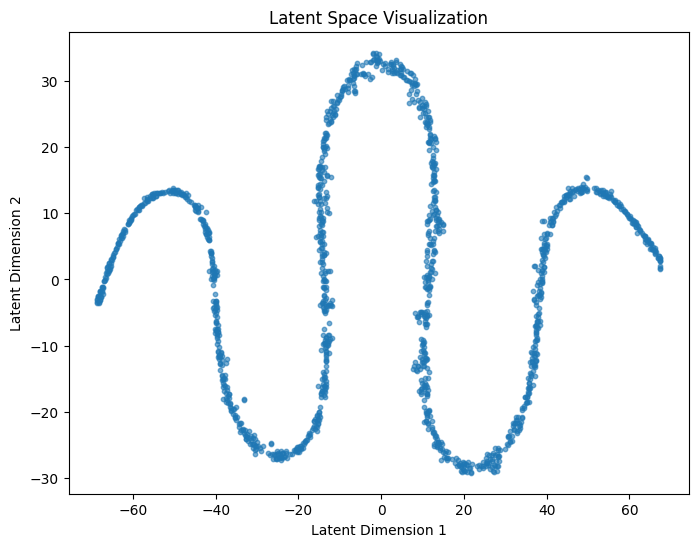

In [52]:
tsne = TSNE(n_components=2, random_state=42)
reduced_latent = tsne.fit_transform(latent_mu)
m = len(test_x_user_item_matrix[0])
list(np.arange(m))
plt.figure(figsize=(8, 6))
plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], alpha=0.6, s=10)
plt.title("Latent Space Visualization")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()